In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models Regression
import lightgbm as lgb

# Models Classification
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Misc
import math
import shap
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin


import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Utils

In [2]:
def scoringProfit(yTrue, pred, doubleAnalysis = False):
    '''
        Custrom metric to compute profit where TP = 90 and
        FP = -10 in generating the metric
        
        Args:
            yTrue: Array with ground truth
            pred: Array with predict from model
            doubleAnalysis: Boolean to say if return one metric or two
            
        Returns:
            Scorer: Scorer of  profit by customer or 
                    profit by customer and all profit
    '''
    
    # ### Matriz de confusão com (tn,fp,fn,tp)
    crosstab = metrics.confusion_matrix(yTrue, pred)
    
    if len(pred) < 4:
        tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = crosstab.ravel()
    
    # Compute profit
    profit = (tp*90 - fp*10)
    
    # Compute profit per customer
    profitCustomer = profit/len(pred)

    if doubleAnalysis:
        return profitCustomer, profit
        
    return profitCustomer



In [70]:
def thresholdsCurve(y_true = None, y_proba = None):
  '''
      Calculate the best threshold to maximize profit
      
      Args:
        y_true (np.array):
        y_proba (np.array):
  '''
    
  thresholds = np.arange(0.0, 1.0, 0.0005)
  threshold_gain_max = 0.0

  gain_score_eval = list()
  gain_score_max = 0.0

  gain_tp = 90
  gain_fp = -10

  for threshold in thresholds:
    y_pred = np.array(list(map(lambda proba: 1 if proba >= threshold else 0, y_proba[:, 1])))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    total_clientes = int(tp + tn + fp + fn)
    gain = round((tp * gain_tp + fp * gain_fp) / total_clientes, 2)

    gain_score_eval.append(gain)

    if gain >= gain_score_max and threshold >= threshold_gain_max:
      gain_score_max = gain
      threshold_gain_max = threshold
  
  plt.figure(figsize= (5, 5))
  sns.lineplot(x = thresholds, y = gain_score_eval, color= "red")

  plt.text(x = 0.45,
           y = gain_score_max*1.1,
           s = f"THRESHOLD: {threshold_gain_max:.4f},\nLucro Per. Cliente (R$): {gain_score_max:.2f}", 
           bbox = {'facecolor': 'gray','alpha': 0.4, 'pad': 6}
  )

  plt.title("Curva Lucro Per. Cliente(R$) x THRESHOLD")
  plt.legend(["Classe 1 - Insatisfeito"])
  plt.ylim(0, gain_score_max*1.35)
  plt.ylabel("Lucro Per. Cliente(R$)")
  plt.xlabel("Thresholds")
  plt.show()

In [4]:
def computeDist(yTrue, yPred_prob):
    '''
      Calculate the distribution
      
      Args:
        yTrue (np.array): True label
        yPred_prob (np.array): Proba predict by model
  '''
    
    df_dist = pd.DataFrame({'Target': yTrue, 'Proba': yPred_prob[:,1]})
    df_dist.sort_values(by=['Proba'], ascending=False, inplace=True)
    df_dist.reset_index(drop=True,inplace=True)
    df_dist['Decile']=pd.qcut(df_dist.index,100,labels=False)
    
    output_df_dist = pd.DataFrame()
    output_df_dist['Percentil'] = list(range(1,101))
    grouped = df_dist.groupby('Decile',as_index=False)
    output_df_dist['Qtd']=grouped.count().Target
    output_df_dist['Sum_Target']=grouped.sum().Target
    output_df_dist['Target_perc'] = (output_df_dist['Sum_Target']/output_df_dist['Sum_Target'].sum())*100
    output_df_dist['Target_AC'] = output_df_dist.Target_perc.cumsum()
    output_df_dist['Max_proba']=grouped.max().Proba
    output_df_dist['Min_proba']=grouped.min().Proba
    output_df_dist["Per_pop"] = (output_df_dist["Qtd"]/len(yTrue))*100
    output_df_dist["Lift"] = output_df_dist["Target_AC"]/output_df_dist.Per_pop.cumsum()
    
    output_df_dist= output_df_dist.drop(columns=['Qtd', 'Sum_Target','Target_perc', 'Per_pop'])
    output_df_dist = output_df_dist.set_index('Percentil')
    
    return output_df_dist.iloc[[0,4, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]]

In [5]:
# Calculate ivariate
def calculateBivariate(df, feature, target, return_table=False, plot=False):
    '''
        Function aiming to analyze the variables 

        Args:
            df: Pandas dataframe containing the variables and target.
            feature: String with the name of the variable to be analyzed.
            target: String with the name of the column representing the target.
            return_table: Boolean to return the table or Information Value.
    '''
    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])

    data['Good'] = data['All'] - data['Bad']
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = data['Good'] / data['Good'].sum()
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['Log Odds'] = np.log(data['Bad']/data['Good'])
    
    if plot:       
        sns.lineplot(data=data, x='Value', y='Log Odds')

        return 

    data['Lift'] = data['Bad Rate'] / (data['Bad'].sum() / (data['All'].sum()))
        
    data['WoE'] = np.log(data['Distribution Good']/data['Distribution Bad'])

    for idx in range(len(data['Distribution Good'])):
        if data['Distribution Bad'].iloc[idx] == 0 or data['Distribution Good'].iloc[idx] == 0:
            data['WoE'].iloc[idx] = np.log((data['Distribution Good'].iloc[idx] + 0.5) / (data['Distribution Bad'].iloc[idx] + 0.5))
        
    
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if return_table:
        return data

    return data['IV'][0]

In [6]:
def dropDuplicatedRows(df, cols, keep=False):
    print(f'Dataset antes do processamento: {df.shape}')
    dfResult = df.drop_duplicates(subset=cols, inplace=False,keep=keep)
    print(f'Dataset após o processamento: {dfResult.shape}')
    return dfResult

# Carregamento dos Dados

In [7]:
dfTrain = pd.read_csv('train_features.csv')
#yTrain = dfTrain.TARGET
#dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

dfVal = pd.read_csv('val_features.csv')
#yVal = dfVal.TARGET
#dfVal = dfVal.drop(labels=['TARGET'], axis=1)

dfTest = pd.read_csv('test_features.csv')

Proporção dos targets positivos no dataset de Treino: 3.78%
Número de clientes satisfeitos: 54611
Número de clientes insatisfeitos: 2146


Text(0.5, 1.0, 'Total de registros por classe')

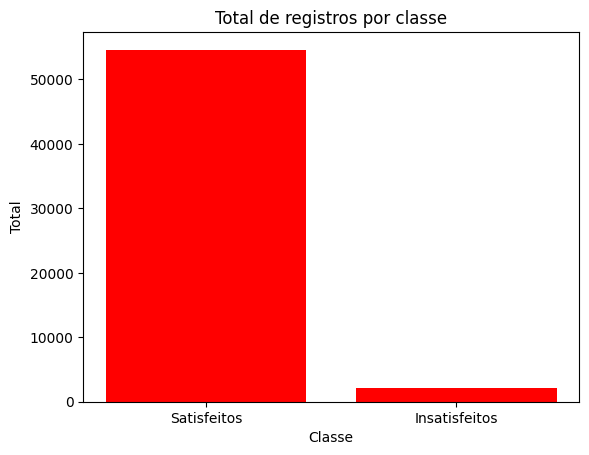

In [8]:
# ### Count by class
targetCounts  = dfTrain['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfTrain['TARGET']))
print(f'Proporção dos targets positivos no dataset de Treino: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

Proporção dos targets positivos no dataset de Validação: 3.78%
Número de clientes satisfeitos: 13654
Número de clientes insatisfeitos: 536


Text(0.5, 1.0, 'Total de registros por classe')

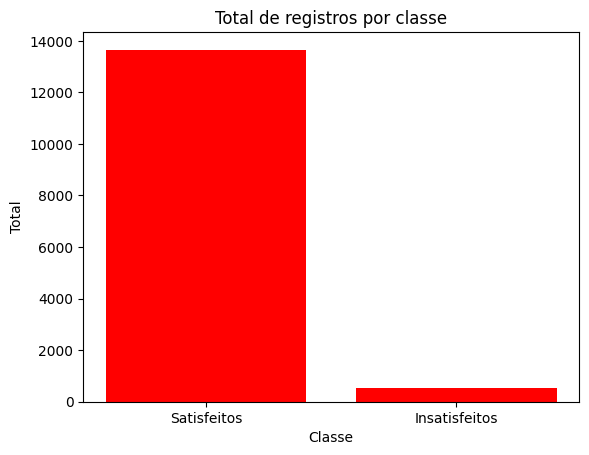

In [9]:
# ### Count by class
targetCounts  = dfVal['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfVal['TARGET']))
print(f'Proporção dos targets positivos no dataset de Validação: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

# Análise Bivariada

In [10]:
cols = dfTrain.columns

## Var3

In [11]:
calculateBivariate(dfTrain, cols[0], 'TARGET', True).style

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
12,var3,0,57,3,54,0.052632,0.000989,0.001398,-2.890372,1.391990,-0.346258,0.009460
4,var3,1,79,8,71,0.101266,0.001300,0.003728,-2.183238,2.678259,-1.053391,0.009460
0,var3,2,55360,2102,53258,0.037970,0.975225,0.979497,-3.232259,1.004214,-0.004371,0.009460
7,var3,3,81,1,80,0.012346,0.001465,0.000466,-4.382027,0.326516,1.145397,0.009460
23,var3,4,63,3,60,0.047619,0.001099,0.001398,-2.995732,1.259420,-0.240897,0.009460
15,var3,5,54,2,52,0.037037,0.000952,0.000932,-3.258097,0.979549,0.021467,0.009460
10,var3,6,67,2,65,0.029851,0.001190,0.000932,-3.481240,0.789487,0.244610,0.009460
3,var3,7,85,3,82,0.035294,0.001502,0.001398,-3.308107,0.933452,0.071477,0.009460
9,var3,8,111,4,107,0.036036,0.001959,0.001864,-3.286534,0.953074,0.049905,0.009460
1,var3,9,88,4,84,0.045455,0.001538,0.001864,-3.044522,1.202173,-0.192107,0.009460


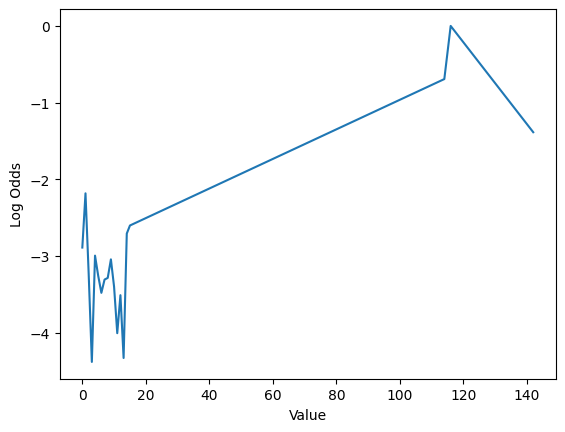

In [12]:
calculateBivariate(dfTrain, cols[0], 'TARGET', True, True)

## var15

In [13]:
calculateBivariate(dfTrain, cols[1], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
34,var15,22,886,0,886,0.000000,0.016224,0.000000,-inf,0.000000,0.031932,0.725134
0,var15,23,14402,95,14307,0.006596,0.261980,0.044268,-5.014627,0.174458,1.777998,0.725134
22,var15,24,4565,50,4515,0.010953,0.082676,0.023299,-4.503137,0.289680,1.266508,0.725134
4,var15,25,3135,50,3085,0.015949,0.056490,0.023299,-4.122284,0.421815,0.885654,0.725134
27,var15,26,2463,64,2399,0.025985,0.043929,0.029823,-3.623924,0.687235,0.387294,0.725134
...,...,...,...,...,...,...,...,...,...,...,...,...
79,var15,99,5,0,5,0.000000,0.000092,0.000000,-inf,0.000000,0.000183,0.725134
76,var15,100,4,0,4,0.000000,0.000073,0.000000,-inf,0.000000,0.000146,0.725134
74,var15,101,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.725134
77,var15,102,3,1,2,0.333333,0.000037,0.000466,-0.693147,8.815937,-2.543483,0.725134


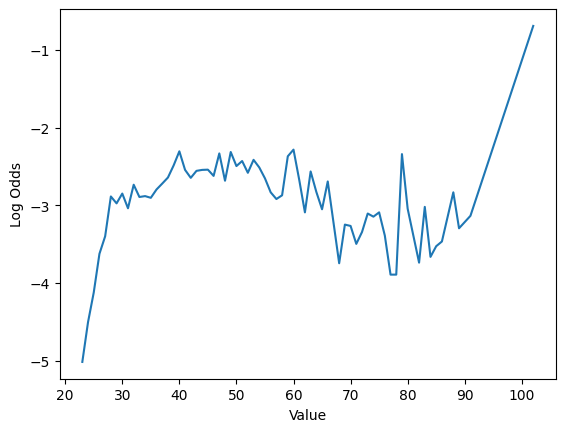

In [14]:
calculateBivariate(dfTrain, cols[1], 'TARGET', True, True)

## imp_ent_var16_ult1

In [15]:
calculateBivariate(dfTrain, cols[2], 'TARGET', True).style

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,imp_ent_var16_ult1,0.000000,53785,2009,51776,0.037352,0.948087,0.936160,-3.249290,0.987890,0.012660,0.032395
346,imp_ent_var16_ult1,0.060000,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.032395
352,imp_ent_var16_ult1,0.300000,2,0,2,0.000000,0.000037,0.000000,-inf,0.000000,0.000073,0.032395
419,imp_ent_var16_ult1,1.200000,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.032395
260,imp_ent_var16_ult1,1.500000,2,0,2,0.000000,0.000037,0.000000,-inf,0.000000,0.000073,0.032395
272,imp_ent_var16_ult1,2.910000,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.032395
61,imp_ent_var16_ult1,3.000000,108,7,101,0.064815,0.001849,0.003262,-2.669210,1.714210,-0.567419,0.032395
48,imp_ent_var16_ult1,6.000000,15,1,14,0.066667,0.000256,0.000466,-2.639057,1.763187,-0.597572,0.032395
211,imp_ent_var16_ult1,9.000000,3,1,2,0.333333,0.000037,0.000466,-0.693147,8.815937,-2.543483,0.032395
290,imp_ent_var16_ult1,9.360000,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.032395


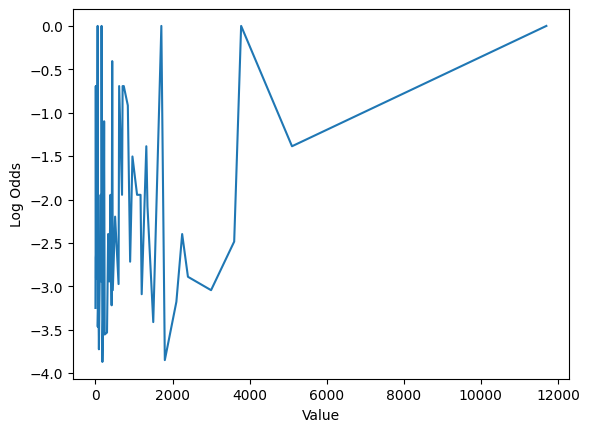

In [16]:
calculateBivariate(dfTrain, cols[2], 'TARGET', True, True)

## imp_op_var41_efect_ult1

In [17]:
calculateBivariate(dfTrain, cols[3], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,imp_op_var41_efect_ult1,0.00,51448,1904,49544,0.037008,0.907216,0.887232,-3.258904,0.978787,0.022275,0.070221
63,imp_op_var41_efect_ult1,15.00,7,0,7,0.000000,0.000128,0.000000,-inf,0.000000,0.000256,0.070221
139,imp_op_var41_efect_ult1,16.65,3,0,3,0.000000,0.000055,0.000000,-inf,0.000000,0.000110,0.070221
89,imp_op_var41_efect_ult1,27.00,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.070221
275,imp_op_var41_efect_ult1,27.93,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.070221
...,...,...,...,...,...,...,...,...,...,...,...,...
188,imp_op_var41_efect_ult1,10350.00,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.070221
204,imp_op_var41_efect_ult1,10500.00,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.070221
235,imp_op_var41_efect_ult1,12600.00,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.070221
126,imp_op_var41_efect_ult1,13110.00,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.070221


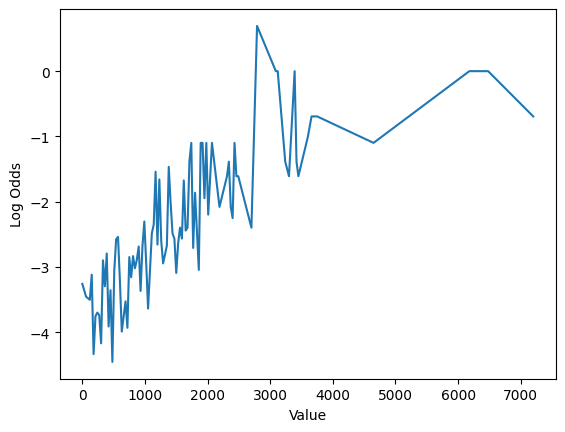

In [18]:
calculateBivariate(dfTrain, cols[3], 'TARGET', True, True)

## ind_var1_0

In [19]:
calculateBivariate(dfTrain, cols[4], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,ind_var1_0,0,56061,2115,53946,0.037727,0.987823,0.985555,-3.238929,0.997790,0.002299,0.000393
1,ind_var1_0,1,696,31,665,0.044540,0.012177,0.014445,-3.065800,1.177992,-0.170830,0.000393


## ind_var25_cte

In [20]:
calculateBivariate(dfTrain, cols[5], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,ind_var25_cte,0,55140,2039,53101,0.036979,0.97235,0.95014,-3.259736,0.978003,0.023107,0.013608
1,ind_var25_cte,1,1617,107,1510,0.066172,0.02765,0.04986,-2.647036,1.750102,-0.589594,0.013608


## num_var4

In [21]:
calculateBivariate(dfTrain, cols[6], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
1,num_var4,0,13240,1137,12103,0.085876,0.221622,0.529823,-2.365060,2.271236,-0.871570,0.486303
0,num_var4,1,28864,537,28327,0.018604,0.518705,0.250233,-3.965573,0.492048,0.728943,0.486303
2,num_var4,2,10160,278,9882,0.027362,0.180953,0.129543,-3.570849,0.723670,0.334219,0.486303
4,num_var4,3,3464,143,3321,0.041282,0.060812,0.066636,-3.145177,1.091812,-0.091453,0.486303
3,num_var4,4,844,48,796,0.056872,0.014576,0.022367,-2.808398,1.504141,-0.428232,0.486303
5,num_var4,5,154,3,151,0.019481,0.002765,0.001398,-3.918668,0.515217,0.682038,0.486303
6,num_var4,6,31,0,31,0.000000,0.000568,0.000000,-inf,0.000000,0.001135,0.486303


## num_op_var41_hace2

In [22]:
calculateBivariate(dfTrain, cols[7], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_op_var41_hace2,0,50086,1893,48193,0.037795,0.882478,0.882106,-3.237051,0.999595,0.000421,0.012525
1,num_op_var41_hace2,3,2084,64,2020,0.030710,0.036989,0.029823,-3.451970,0.812217,0.215340,0.012525
4,num_op_var41_hace2,6,1131,35,1096,0.030946,0.020069,0.016309,-3.444074,0.818456,0.207445,0.012525
5,num_op_var41_hace2,9,690,30,660,0.043478,0.012085,0.013979,-3.091042,1.149905,-0.145587,0.012525
3,num_op_var41_hace2,12,502,19,483,0.037849,0.008844,0.008854,-3.235578,1.001013,-0.001052,0.012525
2,num_op_var41_hace2,15,382,14,368,0.036649,0.006739,0.006524,-3.269026,0.969291,0.032396,0.012525
8,num_op_var41_hace2,18,299,12,287,0.040134,0.005255,0.005592,-3.174576,1.061451,-0.062054,0.012525
9,num_op_var41_hace2,21,247,14,233,0.056680,0.004267,0.006524,-2.811981,1.499066,-0.424649,0.012525
14,num_op_var41_hace2,24,204,7,197,0.034314,0.003607,0.003262,-3.337294,0.907523,0.100664,0.012525
11,num_op_var41_hace2,27,206,12,194,0.058252,0.003552,0.005592,-2.782952,1.540649,-0.453678,0.012525


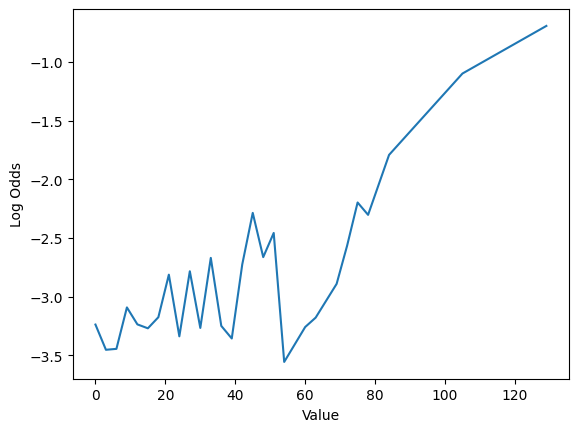

In [23]:
calculateBivariate(dfTrain, cols[7], 'TARGET', True, True)

## num_op_var41_ult1

In [24]:
calculateBivariate(dfTrain, cols[8], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_op_var41_ult1,0,47482,1798,45684,0.037867,0.836535,0.837838,-3.235073,1.001499,-0.001556,0.027777
5,num_op_var41_ult1,3,2280,56,2224,0.024561,0.040724,0.026095,-3.681711,0.649595,0.445081,0.027777
8,num_op_var41_ult1,6,1403,60,1343,0.042766,0.024592,0.027959,-3.108317,1.131054,-0.128313,0.027777
6,num_op_var41_ult1,9,874,24,850,0.027460,0.015565,0.011184,-3.567183,0.726256,0.330553,0.027777
4,num_op_var41_ult1,12,655,28,627,0.042748,0.011481,0.013048,-3.108742,1.130593,-0.127888,0.027777
13,num_op_var41_ult1,15,589,21,568,0.035654,0.010401,0.009786,-3.297599,0.942961,0.060969,0.027777
2,num_op_var41_ult1,18,499,25,474,0.050100,0.008680,0.011650,-2.942331,1.325041,-0.294298,0.027777
1,num_op_var41_ult1,21,398,13,385,0.032663,0.007050,0.006058,-3.388294,0.863873,0.151664,0.027777
10,num_op_var41_ult1,24,330,10,320,0.030303,0.005860,0.004660,-3.465736,0.801449,0.229106,0.027777
19,num_op_var41_ult1,27,306,11,295,0.035948,0.005402,0.005126,-3.289080,0.950738,0.052450,0.027777


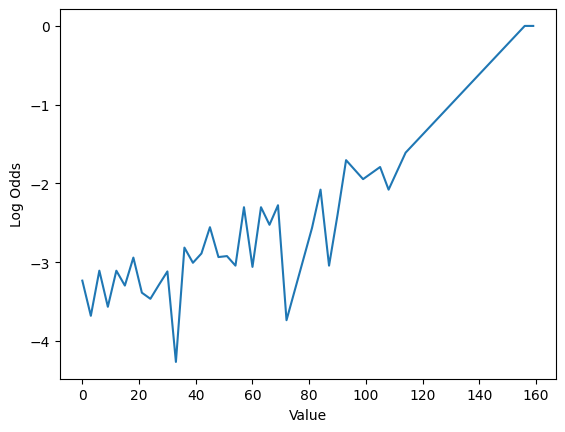

In [25]:
calculateBivariate(dfTrain, cols[8], 'TARGET', True, True)

## num_var30_0

In [26]:
calculateBivariate(dfTrain, cols[9], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
4,num_var30_0,0,272,2,270,0.007353,0.004944,0.000932,-4.905275,0.194469,1.668645,0.081388
0,num_var30_0,3,50472,2059,48413,0.040795,0.886506,0.959459,-3.157548,1.078936,-0.079082,0.081388
1,num_var30_0,6,4497,70,4427,0.015566,0.081064,0.032619,-4.146982,0.411685,0.910353,0.081388
2,num_var30_0,9,1379,14,1365,0.010152,0.024995,0.006524,-4.579852,0.268506,1.343223,0.081388
3,num_var30_0,12,120,0,120,0.000000,0.002197,0.000000,-inf,0.000000,0.004385,0.081388
5,num_var30_0,15,12,0,12,0.000000,0.000220,0.000000,-inf,0.000000,0.000439,0.081388
7,num_var30_0,18,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.081388
10,num_var30_0,21,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.081388
9,num_var30_0,24,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.081388
8,num_var30_0,33,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.081388


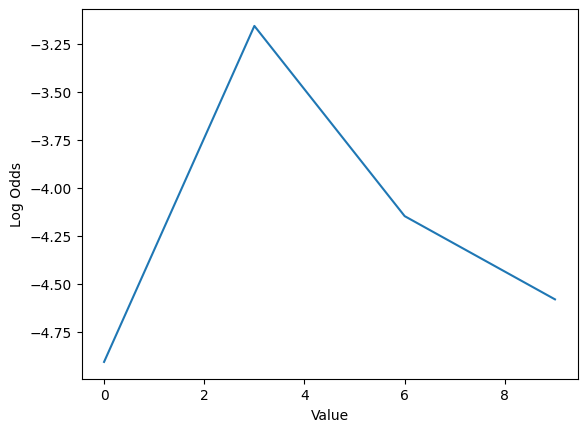

In [27]:
calculateBivariate(dfTrain, cols[9], 'TARGET', True, True)

## num_var30

In [28]:
calculateBivariate(dfTrain, cols[10], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
1,num_var30,0,13854,1173,12681,0.084669,0.232206,0.546598,-2.380540,2.239301,-0.856089,0.456831
0,num_var30,3,39533,938,38595,0.023727,0.706726,0.437092,-3.717128,0.627528,0.480498,0.456831
2,num_var30,6,3098,33,3065,0.010652,0.056124,0.015377,-4.531295,0.281723,1.294666,0.456831
4,num_var30,9,242,2,240,0.008264,0.004395,0.000932,-4.787492,0.218577,1.550862,0.456831
3,num_var30,10,30,0,30,0.000000,0.000549,0.000000,-inf,0.000000,0.001098,0.456831


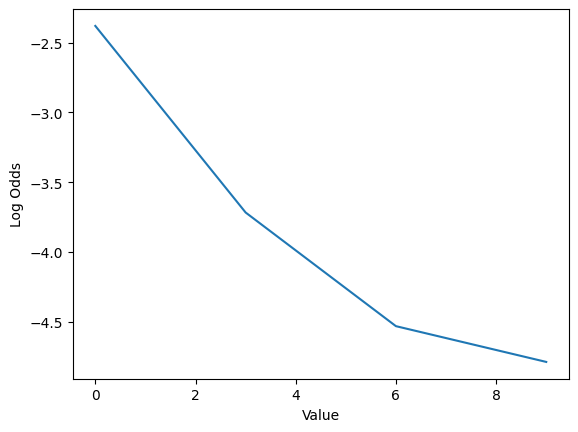

In [29]:
calculateBivariate(dfTrain, cols[10], 'TARGET', True, True)

## num_var37_med_ult2

In [30]:
calculateBivariate(dfTrain, cols[11], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_var37_med_ult2,0,53946,2036,51910,0.037741,0.950541,0.948742,-3.238524,0.998179,0.001895,0.002973
1,num_var37_med_ult2,3,1673,69,1604,0.041243,0.029371,0.032153,-3.146149,1.090794,-0.090480,0.002973
2,num_var37_med_ult2,6,614,17,597,0.027687,0.010932,0.007922,-3.558704,0.732268,0.322074,0.002973
6,num_var37_med_ult2,9,249,14,235,0.056225,0.004303,0.006524,-2.820528,1.487025,-0.416101,0.002973
3,num_var37_med_ult2,12,107,3,104,0.028037,0.001904,0.001398,-3.545779,0.741527,0.309149,0.002973
5,num_var37_med_ult2,15,69,3,66,0.043478,0.001209,0.001398,-3.091042,1.149905,-0.145587,0.002973
7,num_var37_med_ult2,18,36,2,34,0.055556,0.000623,0.000932,-2.833213,1.469323,-0.403416,0.002973
8,num_var37_med_ult2,21,24,0,24,0.000000,0.000439,0.000000,-inf,0.000000,0.000879,0.002973
11,num_var37_med_ult2,24,6,0,6,0.000000,0.000110,0.000000,-inf,0.000000,0.000220,0.002973
4,num_var37_med_ult2,27,9,0,9,0.000000,0.000165,0.000000,-inf,0.000000,0.000330,0.002973


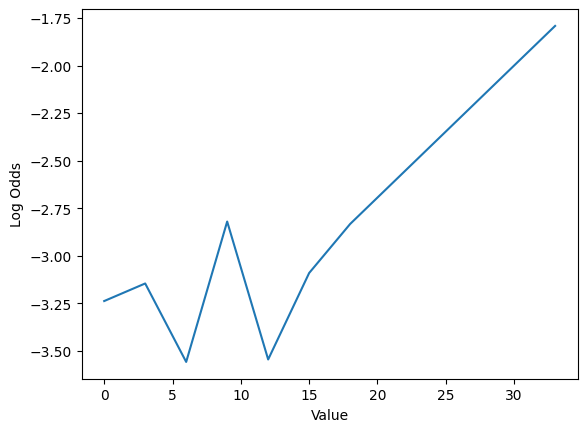

In [31]:
calculateBivariate(dfTrain, cols[11], 'TARGET', True, True)

## saldo_var5

In [32]:
calculateBivariate(dfTrain, cols[12], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
7940,saldo_var5,-1842.00,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.62479
8784,saldo_var5,-1730.28,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.62479
5246,saldo_var5,-1496.64,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
1203,saldo_var5,-928.65,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
9144,saldo_var5,-852.69,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
...,...,...,...,...,...,...,...,...,...,...,...,...
7541,saldo_var5,132371.61,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
6066,saldo_var5,134995.53,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
2689,saldo_var5,135790.41,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.62479
9088,saldo_var5,137614.62,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.62479


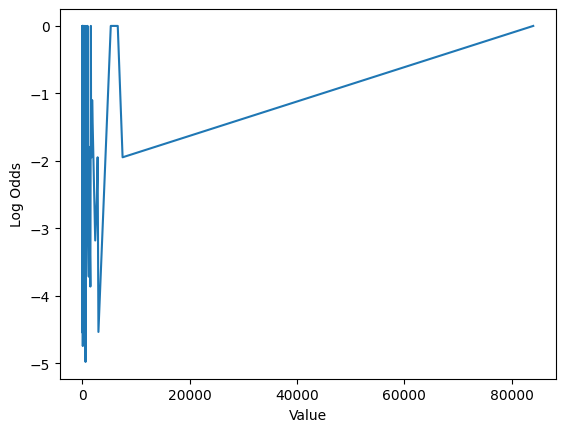

In [33]:
calculateBivariate(dfTrain, cols[12], 'TARGET', True, True)

## saldo_var30

In [34]:
calculateBivariate(dfTrain, cols[13], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
8339,saldo_var30,-2994.93,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
11318,saldo_var30,-1842.00,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.731996
10000,saldo_var30,-1802.01,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
13641,saldo_var30,-1774.80,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
12615,saldo_var30,-1730.28,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.731996
...,...,...,...,...,...,...,...,...,...,...,...,...
2657,saldo_var30,503730.66,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
11851,saldo_var30,504075.54,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
423,saldo_var30,505145.16,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.731996
5086,saldo_var30,506443.14,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.731996


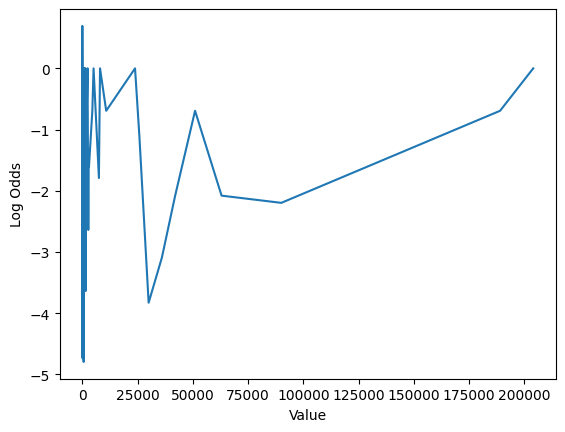

In [35]:
calculateBivariate(dfTrain, cols[13], 'TARGET', True, True)

## saldo_var37

In [36]:
calculateBivariate(dfTrain, cols[14], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,saldo_var37,0.00,52825,1975,50850,0.037388,0.931131,0.920317,-3.248312,0.98882,0.011682,0.047156
1707,saldo_var37,0.27,1,0,1,0.000000,0.000018,0.000000,-inf,0.00000,0.000037,0.047156
69,saldo_var37,0.30,1,0,1,0.000000,0.000018,0.000000,-inf,0.00000,0.000037,0.047156
108,saldo_var37,0.33,3,0,3,0.000000,0.000055,0.000000,-inf,0.00000,0.000110,0.047156
1578,saldo_var37,0.42,1,0,1,0.000000,0.000018,0.000000,-inf,0.00000,0.000037,0.047156
...,...,...,...,...,...,...,...,...,...,...,...,...
3271,saldo_var37,11118.21,1,0,1,0.000000,0.000018,0.000000,-inf,0.00000,0.000037,0.047156
1000,saldo_var37,15000.00,2,0,2,0.000000,0.000037,0.000000,-inf,0.00000,0.000073,0.047156
759,saldo_var37,21000.00,1,0,1,0.000000,0.000018,0.000000,-inf,0.00000,0.000037,0.047156
2559,saldo_var37,21261.09,1,1,0,1.000000,0.000000,0.000466,inf,26.44781,-0.000932,0.047156


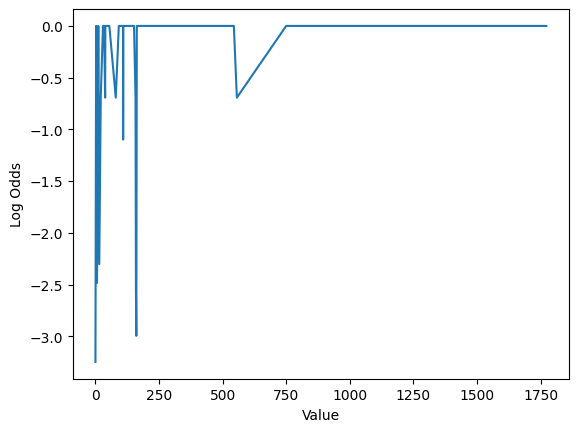

In [37]:
calculateBivariate(dfTrain, cols[14], 'TARGET', True, True)

## imp_aport_var13_hace3

In [38]:
calculateBivariate(dfTrain, cols[15], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,imp_aport_var13_hace3,0.0,55418,2143,53275,0.038670,0.975536,0.998602,-3.213260,1.022730,-0.023369,0.001302
39,imp_aport_var13_hace3,300.0,16,0,16,0.000000,0.000293,0.000000,-inf,0.000000,0.000586,0.001302
170,imp_aport_var13_hace3,315.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
134,imp_aport_var13_hace3,450.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
71,imp_aport_var13_hace3,600.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
...,...,...,...,...,...,...,...,...,...,...,...,...
88,imp_aport_var13_hace3,117300.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
111,imp_aport_var13_hace3,117600.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
92,imp_aport_var13_hace3,118503.0,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.001302
12,imp_aport_var13_hace3,120000.0,48,1,47,0.020833,0.000861,0.000466,-3.850148,0.550996,0.613518,0.001302


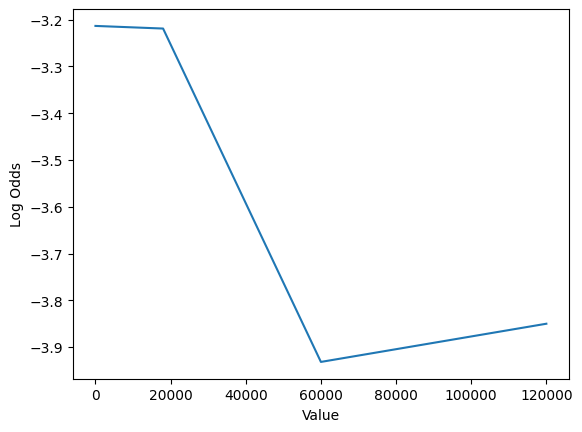

In [39]:
calculateBivariate(dfTrain, cols[15], 'TARGET', True, True)

## num_var22_ult1

In [40]:
calculateBivariate(dfTrain, cols[16], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_var22_ult1,0,50316,1869,48447,0.037145,0.887129,0.870923,-3.255067,0.982410,0.018437,0.0227
3,num_var22_ult1,3,3872,130,3742,0.033574,0.068521,0.060578,-3.359841,0.887969,0.123211,0.0227
2,num_var22_ult1,6,1454,61,1393,0.041953,0.025508,0.028425,-3.128341,1.109571,-0.108289,0.0227
1,num_var22_ult1,9,586,35,551,0.059727,0.010090,0.016309,-2.756387,1.579647,-0.480243,0.0227
7,num_var22_ult1,12,251,17,234,0.067729,0.004285,0.007922,-2.622108,1.791286,-0.614522,0.0227
5,num_var22_ult1,15,139,16,123,0.115108,0.002252,0.007456,-2.039596,3.044352,-1.197034,0.0227
6,num_var22_ult1,18,61,6,55,0.098361,0.001007,0.002796,-2.215574,2.601424,-1.021056,0.0227
13,num_var22_ult1,21,35,5,30,0.142857,0.000549,0.002330,-1.791759,3.778259,-1.444870,0.0227
8,num_var22_ult1,24,14,4,10,0.285714,0.000183,0.001864,-0.916291,7.556517,-2.320339,0.0227
10,num_var22_ult1,27,11,1,10,0.090909,0.000183,0.000466,-2.302585,2.404346,-0.934045,0.0227


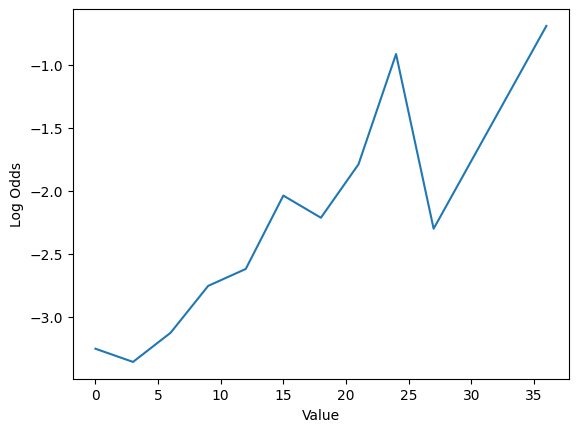

In [41]:
calculateBivariate(dfTrain, cols[16], 'TARGET', True, True)

## num_var22_ult3

In [42]:
calculateBivariate(dfTrain, cols[17], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_var22_ult3,0,35987,1346,34641,0.037402,0.634323,0.627213,-3.247901,0.989211,0.011271,0.019781
2,num_var22_ult3,3,7272,279,6993,0.038366,0.128051,0.130009,-3.221453,1.014706,-0.015177,0.019781
1,num_var22_ult3,6,4489,147,4342,0.032747,0.079508,0.068500,-3.385658,0.866079,0.149028,0.019781
4,num_var22_ult3,9,2998,110,2888,0.036691,0.052883,0.051258,-3.267839,0.970400,0.031209,0.019781
5,num_var22_ult3,12,2024,82,1942,0.040514,0.035561,0.038211,-3.164754,1.071502,-0.071875,0.019781
3,num_var22_ult3,15,1334,44,1290,0.032984,0.023622,0.020503,-3.378208,0.872342,0.141578,0.019781
12,num_var22_ult3,18,878,38,840,0.043280,0.015382,0.017707,-3.095816,1.144666,-0.140814,0.019781
11,num_var22_ult3,21,576,22,554,0.038194,0.010144,0.010252,-3.226122,1.010159,-0.010507,0.019781
9,num_var22_ult3,24,388,14,374,0.036082,0.006848,0.006524,-3.285198,0.954302,0.048569,0.019781
14,num_var22_ult3,27,243,17,226,0.069959,0.004138,0.007922,-2.587322,1.850258,-0.649308,0.019781


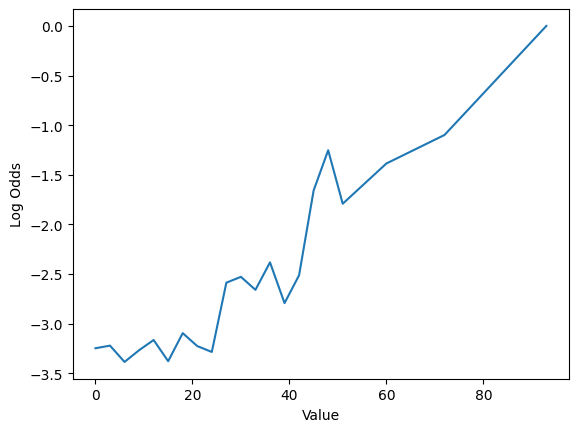

In [43]:
calculateBivariate(dfTrain, cols[17], 'TARGET', True, True)

## num_meses_var8_ult3

In [44]:
calculateBivariate(dfTrain, cols[18], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_meses_var8_ult3,0,54978,2018,52960,0.036706,0.969768,0.940354,-3.267430,0.970783,0.030800,0.021439
3,num_meses_var8_ult3,1,677,55,622,0.081241,0.011390,0.025629,-2.425607,2.148640,-0.811023,0.021439
1,num_meses_var8_ult3,2,723,47,676,0.065007,0.012378,0.021901,-2.666045,1.719291,-0.570584,0.021439
2,num_meses_var8_ult3,3,379,26,353,0.068602,0.006464,0.012116,-2.608372,1.814362,-0.628258,0.021439


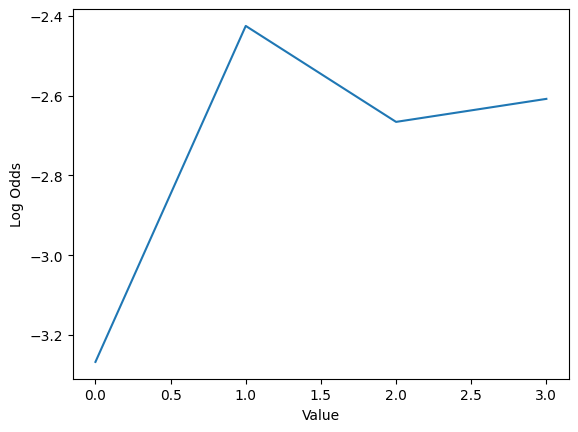

In [45]:
calculateBivariate(dfTrain, cols[18], 'TARGET', True, True)

## num_var43_emit_ult1

In [46]:
calculateBivariate(dfTrain, cols[19], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,num_var43_emit_ult1,0,52741,2011,50730,0.038130,0.928934,0.937092,-3.227885,1.008448,-0.008744,0.004912
2,num_var43_emit_ult1,3,2390,73,2317,0.030544,0.042427,0.034017,-3.457569,0.807820,0.220939,0.004912
3,num_var43_emit_ult1,6,832,31,801,0.037260,0.014667,0.014445,-3.251874,0.985435,0.015244,0.004912
5,num_var43_emit_ult1,9,362,17,345,0.046961,0.006317,0.007922,-3.010331,1.242024,-0.226299,0.004912
4,num_var43_emit_ult1,12,167,6,161,0.035928,0.002948,0.002796,-3.289645,0.950221,0.053015,0.004912
6,num_var43_emit_ult1,15,91,0,91,0.000000,0.001666,0.000000,-inf,0.000000,0.003327,0.004912
8,num_var43_emit_ult1,18,48,4,44,0.083333,0.000806,0.001864,-2.397895,2.203984,-0.838734,0.004912
7,num_var43_emit_ult1,21,38,1,37,0.026316,0.000678,0.000466,-3.610918,0.695995,0.374288,0.004912
9,num_var43_emit_ult1,24,20,3,17,0.150000,0.000311,0.001398,-1.734601,3.967171,-1.502029,0.004912
1,num_var43_emit_ult1,25,68,0,68,0.000000,0.001245,0.000000,-inf,0.000000,0.002487,0.004912


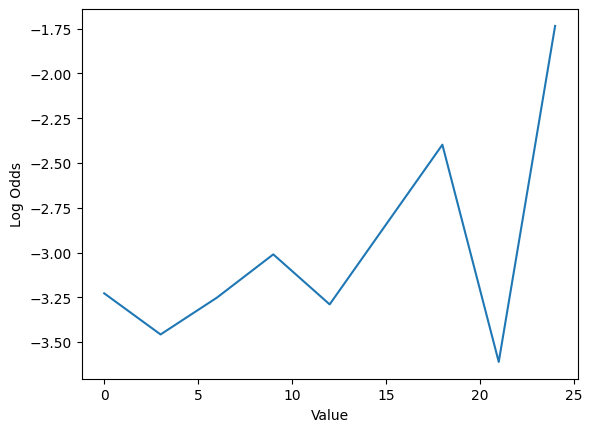

In [47]:
calculateBivariate(dfTrain, cols[19], 'TARGET', True, True)

## saldo_medio_var5_hace2

In [48]:
calculateBivariate(dfTrain, cols[20], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
8272,saldo_medio_var5_hace2,-48.00,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
10267,saldo_medio_var5_hace2,-47.13,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.774492
7878,saldo_medio_var5_hace2,-46.32,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
11196,saldo_medio_var5_hace2,-38.97,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
1536,saldo_medio_var5_hace2,-29.76,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
...,...,...,...,...,...,...,...,...,...,...,...,...
3394,saldo_medio_var5_hace2,164085.78,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
5627,saldo_medio_var5_hace2,164290.74,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
9410,saldo_medio_var5_hace2,165000.00,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.774492
3700,saldo_medio_var5_hace2,165500.01,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.774492


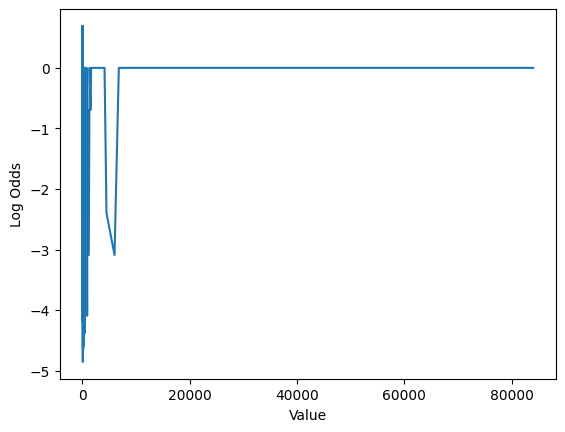

In [49]:
calculateBivariate(dfTrain, cols[20], 'TARGET', True, True)

## saldo_medio_var5_hace3

In [50]:
calculateBivariate(dfTrain, cols[21], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
4886,saldo_medio_var5_hace3,-8.04,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.535199
570,saldo_medio_var5_hace3,-6.09,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.535199
278,saldo_medio_var5_hace3,-4.77,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.535199
2,saldo_medio_var5_hace3,0.00,21197,1436,19761,0.067745,0.361850,0.669152,-2.621849,1.791718,-0.614781,0.535199
275,saldo_medio_var5_hace3,0.03,22,1,21,0.045455,0.000385,0.000466,-3.044522,1.202173,-0.192107,0.535199
...,...,...,...,...,...,...,...,...,...,...,...,...
3135,saldo_medio_var5_hace3,16707.75,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.535199
5430,saldo_medio_var5_hace3,16741.92,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.535199
837,saldo_medio_var5_hace3,16800.00,2,0,2,0.000000,0.000037,0.000000,-inf,0.000000,0.000073,0.535199
4516,saldo_medio_var5_hace3,16935.48,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.535199


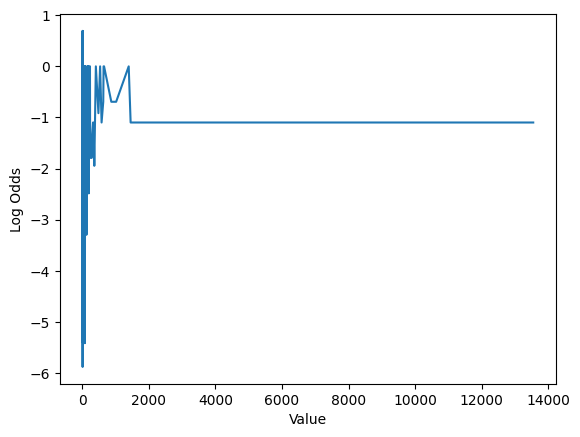

In [51]:
calculateBivariate(dfTrain, cols[21], 'TARGET', True, True)

## saldo_medio_var5_ult3

In [52]:
calculateBivariate(dfTrain, cols[22], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
2019,saldo_medio_var5_ult3,-476.07,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
12412,saldo_medio_var5_ult3,-173.64,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.724708
13501,saldo_medio_var5_ult3,-101.79,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
5572,saldo_medio_var5_ult3,-77.04,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
2666,saldo_medio_var5_ult3,-62.97,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.724708
...,...,...,...,...,...,...,...,...,...,...,...,...
3234,saldo_medio_var5_ult3,104533.32,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
4686,saldo_medio_var5_ult3,106748.58,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
5183,saldo_medio_var5_ult3,108124.80,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.724708
4624,saldo_medio_var5_ult3,108250.02,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.724708


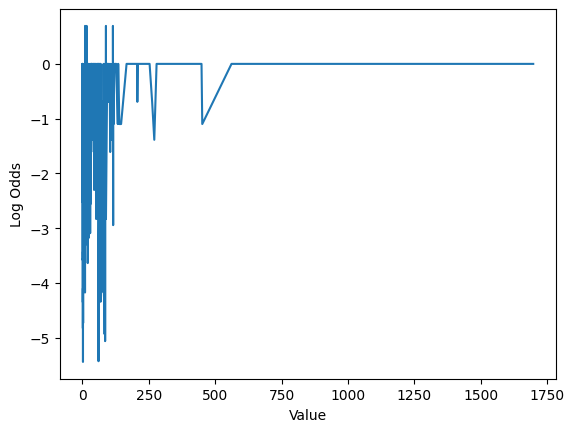

In [53]:
calculateBivariate(dfTrain, cols[22], 'TARGET', True, True)

## saldo_medio_var8_hace3

In [54]:
calculateBivariate(dfTrain, cols[23], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
0,saldo_medio_var8_hace3,0.00,56373,2118,54255,0.037571,0.993481,0.986952,-3.243223,0.993675,0.006593,0.008361
153,saldo_medio_var8_hace3,0.09,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.008361
19,saldo_medio_var8_hace3,0.18,3,1,2,0.333333,0.000037,0.000466,-0.693147,8.815937,-2.543483,0.008361
281,saldo_medio_var8_hace3,0.21,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.008361
108,saldo_medio_var8_hace3,0.30,3,0,3,0.000000,0.000055,0.000000,-inf,0.000000,0.000110,0.008361
...,...,...,...,...,...,...,...,...,...,...,...,...
147,saldo_medio_var8_hace3,1207.32,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.008361
260,saldo_medio_var8_hace3,1354.89,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.008361
198,saldo_medio_var8_hace3,1400.25,1,0,1,0.000000,0.000018,0.000000,-inf,0.000000,0.000037,0.008361
263,saldo_medio_var8_hace3,1414.35,1,1,0,1.000000,0.000000,0.000466,inf,26.447810,-0.000932,0.008361


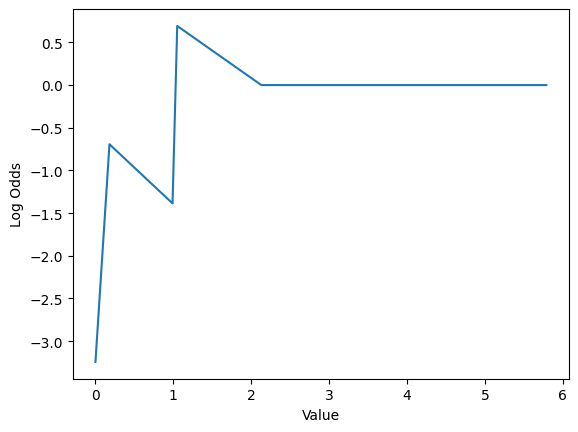

In [55]:
calculateBivariate(dfTrain, cols[23], 'TARGET', True, True)

## var38

In [56]:
calculateBivariate(dfTrain, cols[24], 'TARGET', True)

,Variable,Value,All,Bad,Good,Bad Rate,Distribution Good,Distribution Bad,Log Odds,Lift,WoE,IV
11455,var38,11135.00,10,0,10,0.0,0.000183,0.000000,-inf,0.00000,0.000366,0.167441
13938,var38,11136.63,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.167441
30018,var38,11325.36,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
7625,var38,11448.00,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
21190,var38,11554.80,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
...,...,...,...,...,...,...,...,...,...,...,...,...
9123,var38,3367882.41,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
40129,var38,3436722.81,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
31353,var38,3819772.77,1,0,1,0.0,0.000018,0.000000,-inf,0.00000,0.000037,0.167441
39856,var38,3988595.10,1,1,0,1.0,0.000000,0.000466,inf,26.44781,-0.000932,0.167441


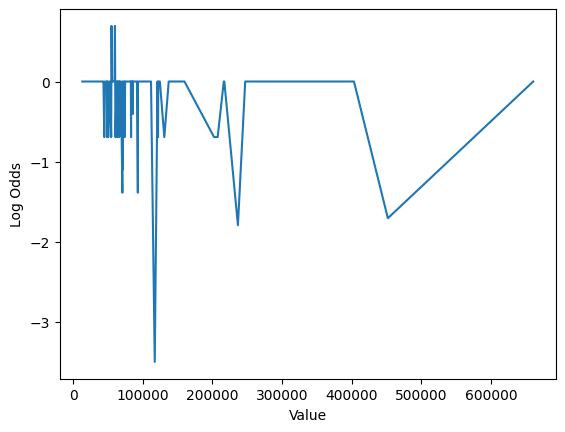

In [57]:
calculateBivariate(dfTrain, cols[24], 'TARGET', True, True)

# Seleção das Features finais

In [10]:
cols = ['var15',  'saldo_var30', 'var38', 'saldo_medio_var5_ult3', 'saldo_medio_var5_hace3', 
'num_var30', 'num_var22_ult3', 'saldo_var5', 'saldo_medio_var5_hace2', 'num_var4', 'imp_op_var41_efect_ult1',  
'num_var22_ult1', 'imp_ent_var16_ult1', 'num_op_var41_ult1', 'num_var30_0', 'num_op_var41_hace2']

In [11]:
dfTrain = dfTrain[cols + ['TARGET']]

dfVal = dfVal[cols + ['TARGET']]

dfTest = dfTest[cols]

# Remover dados duplicados

In [12]:
# ### Remove duplicated Data on Train and keep one element
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns, 'last')

Dataset antes do processamento: (56757, 17)
Dataset após o processamento: (55685, 17)


In [13]:
# Remove All Duplicated elements where the target is different on Train
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns.drop('TARGET'))

Dataset antes do processamento: (55685, 17)
Dataset após o processamento: (55605, 17)


In [14]:
# ### Remove duplicated Data on Val and keep one element
dfVal = dropDuplicatedRows(dfVal, dfVal.columns, 'last')

Dataset antes do processamento: (14190, 17)
Dataset após o processamento: (14090, 17)


In [15]:
# Remove All Duplicated elements where the target is different on Val
dfVal = dropDuplicatedRows(dfVal, dfVal.columns.drop('TARGET'))

Dataset antes do processamento: (14090, 17)
Dataset após o processamento: (14080, 17)


In [16]:
yTrain = dfTrain.TARGET
dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

yVal = dfVal.TARGET
dfVal = dfVal.drop(labels=['TARGET'], axis=1)

Proporção dos targets positivos no dataset de Treino após remoção de duplicadas: 3.77%
Número de clientes satisfeitos: 53507
Número de clientes insatisfeitos: 2098


Text(0.5, 1.0, 'Total de registros por classe')

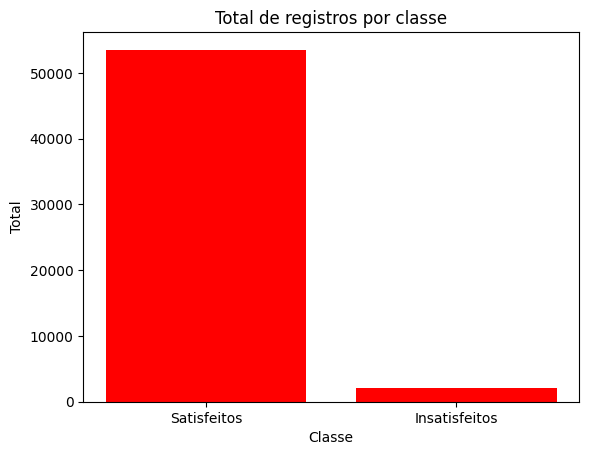

In [17]:
# ### Count by class
targetCounts  = yTrain.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yTrain))
print(f'Proporção dos targets positivos no dataset de Treino após remoção de duplicadas: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

Proporção dos targets positivos no dataset de Validação após remoção de duplicadas: 3.76%
Número de clientes satisfeitos: 13550
Número de clientes insatisfeitos: 530


Text(0.5, 1.0, 'Total de registros por classe')

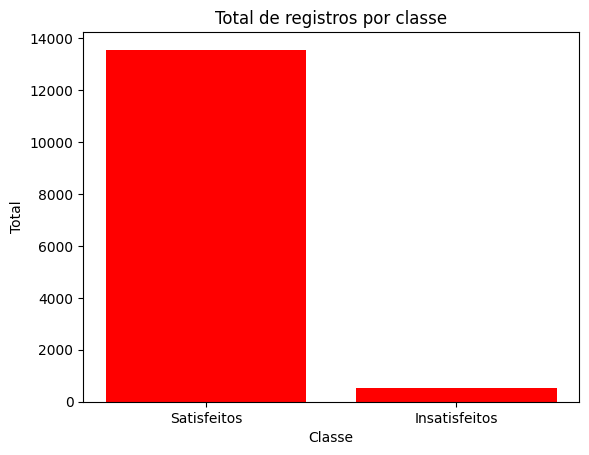

In [18]:
# ### Count by class
targetCounts  = yVal.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yVal))
print(f'Proporção dos targets positivos no dataset de Validação após remoção de duplicadas: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

# Solução

# 1.0 - Classificação (Case A)

## 1.1 - Preparação do Dataset

In [19]:
modelTransform = Pipeline(
                 [
                    ('scale', PowerTransformer(method='yeo-johnson'))
                ]
            )
modelTransform.fit(dfTrain, yTrain)

Pipeline(steps=[('scale', PowerTransformer())])

In [20]:
dfTrainCLF = modelTransform.transform(dfTrain)
dfValCLF = modelTransform.transform(dfVal)
dfTestCLF = modelTransform.transform(dfTest)

## 1.2 - Ponto de Partida

In [69]:
# Model base
clRF = RandomForestClassifier(n_jobs = -1, class_weight='balanced')
clRF.fit(dfTrainCLF, yTrain)
preds = clRF.predict(dfValCLF)
rfPerCustomer, rfProfit = scoringProfit(yVal, preds, True)

# Lucro caso a campanha impacte todos os clientes
allCustomerProfitPerCustomer, allCustomerProfit = scoringProfit(yVal, [1 for i in range(len(yVal))], True)

# Verificação do score máximo possível no treino
maxProfitPerCustomer, maxProfit = (scoringProfit(yVal, yVal, True))

print(f"Lucro no modelo base R${rfProfit:,.2f}")
print(f"Lucro por cliente no modelo base R$ {rfPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfitPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfitPerCustomer:,.2f}")

Lucro no modelo base R$720.00
Lucro por cliente no modelo base R$ 0.05

Lucro caso a capanha seja aplicada a todos os clientes R$ -87,800.00
Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ -6.24

Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 47,700.00
Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 3.39


## 1.3 - Busca dos Melhores Parâmetros

### 1.3.0 - LGBM

In [21]:
def objective(params):
    classifier = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    class_weight='balanced',
                                    objective='binary', 
                                    random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    
    model.fit(dfTrainCLF, yTrain)
    yPred = classifier.predict(dfValCLF)
    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'params': params,
        'status': STATUS_OK 
    }

In [28]:
spaceLGBM = {
    'n_estimators': hp.choice('n_estimators', np.arange(5, 1000, 1, dtype=int)), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
    'max_depth': hp.choice('max_depth', np.arange(6, 30, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(3, 20, 1, dtype=int)), 
    'num_leaves': hp.choice('num_leaves', np.arange(20, 200, 1, dtype=int)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0),

}

In [29]:
trials = Trials ()

bestParamsLGBM = fmin(
    fn=objective,
    space=spaceLGBM,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|████| 1000/1000 [57:42<00:00,  3.46s/trial, best loss: -0.8778409090909091]


In [30]:
print(bestParamsLGBM)

{'colsample_bytree': 0.3626247636489308, 'learning_rate': 0.0329022249766331, 'max_depth': 16, 'min_child_weight': 0, 'n_estimators': 282, 'num_leaves': 126, 'reg_alpha': 0.9460610417309465, 'reg_lambda': 0.7927854519137744, 'subsample': 0.08860512526543718}


### 1.3.1 - XGBoost

In [31]:
def objective(params):
    classifier = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    model.fit(dfTrainCLF, yTrain)

    yPred = classifier.predict(dfValCLF)

    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'status': STATUS_OK, 
        'booster': model.named_steps['classifier'].get_booster().attributes()
    }

In [32]:
spaceXGB = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 1000)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.2, 0.02)),
    'max_depth': scope.int(hp.quniform('max_depth', 6, 30, 1)),
    'scale_pos_weight': scope.int(hp.quniform('scale_pos_weight', 20, 30, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 3, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0)
}

In [33]:
trials = Trials ()

bestParamsXGB = fmin(
    fn=objective,
    space=spaceXGB,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|██████████████| 1000/1000 [22:15<00:00,  1.34s/trial, best loss: -1.015625]


In [34]:
print(bestParamsXGB)

{'colsample_bytree': 0.8993697678743596, 'learning_rate': 0, 'max_depth': 20.0, 'min_child_weight': 3.0, 'n_estimators': 84.50787266499268, 'reg_alpha': 0.14204929543754374, 'reg_lambda': 0.005575527946768863, 'scale_pos_weight': 27.0, 'subsample': 0.11508824490776132}


In [35]:
print(trials.best_trial['result'])

{'loss': -1.015625, 'status': 'ok', 'booster': {}}


## 1.4 - Avaliar Melhor Modelo

### 1.4.0 - LGBM

In [38]:
bestParamsLGBM['n_estimators'] = np.arange(5, 1000, 1, dtype=int)[282]
bestParamsLGBM['max_depth'] = np.arange(6, 30, 1, dtype=int)[16]
bestParamsLGBM['min_child_weight'] = np.arange(3, 20, 1, dtype=int)[0]
bestParamsLGBM['num_leaves'] = np.arange(20, 200, 1, dtype=int)[126]

In [36]:
bestParamsLGBM

{'colsample_bytree': 0.3626247636489308,
 'learning_rate': 0.0329022249766331,
 'max_depth': 16,
 'min_child_weight': 0,
 'n_estimators': 282,
 'num_leaves': 126,
 'reg_alpha': 0.9460610417309465,
 'reg_lambda': 0.7927854519137744,
 'subsample': 0.08860512526543718}

In [39]:
classifierLGBM = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    class_weight='balanced',
                                    objective='binary', 
                                    random_state=424,
                                    **bestParamsLGBM
                                   )

In [40]:
classifierLGBM.fit(dfTrainCLF, yTrain)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.3626247636489308,
               learning_rate=0.0329022249766331, max_depth=22,
               min_child_weight=3, n_estimators=287, n_jobs=-1, num_leaves=146,
               objective='binary', random_state=424,
               reg_alpha=0.9460610417309465, reg_lambda=0.7927854519137744,
               subsample=0.08860512526543718, verbose=-1)

In [73]:
yPred_prob_train = classifierLGBM.predict_proba(dfTrainCLF)
yPred_prob = classifierLGBM.predict_proba(dfValCLF)
yPred_train = classifierLGBM.predict(dfTrainCLF)
yPred = classifierLGBM.predict(dfValCLF)

In [42]:
auc_train = roc_auc_score(yTrain, yPred_prob_train[:,1])
auc_val = roc_auc_score(yVal, yPred_prob[:,1])

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Val: {auc_val:.4f}")

AUC Train: 0.9625
AUC Val: 0.8325


In [43]:
lucro_train = scoringProfit(yTrain, yPred_train)
lucro = scoringProfit(yVal, yPred)

print(f"LUCRO Train: {lucro_train:.4f}")
print(f"LUCRO Val: {lucro:.4f}")

LUCRO Train: 2.0755
LUCRO Val: 0.8778


In [44]:
print("Distribuição no dataset de Treino")
computeDist(yTrain, yPred_prob_train)

Distribuição no dataset de Treino


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,17.397521,0.977453,0.898410,17.367849
5,52.526215,0.860733,0.843632,10.502410
10,84.604385,0.739285,0.700067,8.459678
20,98.903718,0.418627,0.399705,4.945186
30,99.952336,0.253793,0.239707,3.331645
40,100.000000,0.155360,0.147819,2.500000
50,100.000000,0.096606,0.092258,1.999964
60,100.000000,0.059295,0.056711,1.666667
70,100.000000,0.035539,0.033674,1.428590


In [45]:
print("Distribuição no dataset de Validação")
computeDist(yVal, yPred_prob)

Distribuição no dataset de Validação


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,8.113208,0.946114,0.889946,8.101699
5,34.716981,0.848187,0.825911,6.943396
10,53.018868,0.703963,0.665635,5.301887
20,68.301887,0.415383,0.398949,3.415094
30,77.735849,0.260050,0.246674,2.591195
40,84.905660,0.160115,0.152853,2.122642
50,90.377358,0.099934,0.095505,1.807547
60,94.339623,0.061651,0.058485,1.572327
70,96.226415,0.037069,0.035083,1.374663


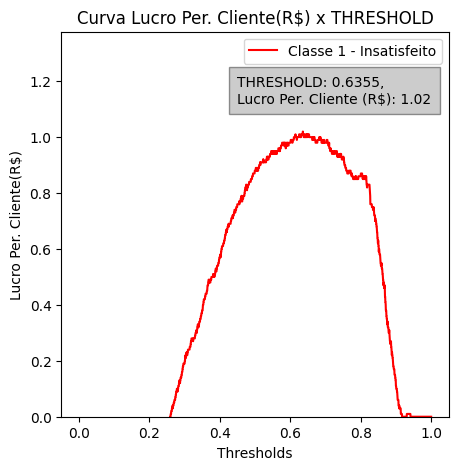

In [74]:
thresholdsCurve(yVal, yPred_prob)

### 1.4.1 - XGBoost

In [47]:
bestParamsXGB['learning_rate'] = np.arange(0.05, 0.2, 0.02)[0]
bestParamsXGB['n_estimators'] = int(bestParamsXGB['n_estimators'])
bestParamsXGB['max_depth'] = int(bestParamsXGB['max_depth'])

In [48]:
classifierXGB = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **bestParamsXGB)
classifierXGB.fit(dfTrainCLF, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8993697678743596, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=84, n_jobs=-1,
              num_parallel_tree=None, random_state=424, ...)

In [75]:
yPred_prob_train = classifierXGB.predict_proba(dfTrainCLF)
yPred_prob = classifierXGB.predict_proba(dfValCLF)
yPred_train = classifierXGB.predict(dfTrainCLF)
yPred = classifierXGB.predict(dfValCLF)

In [50]:
auc_train = roc_auc_score(yTrain, yPred_prob_train[:,1])
auc_val = roc_auc_score(yVal, yPred_prob[:,1])

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Val: {auc_val:.4f}")

AUC Train: 0.9281
AUC Val: 0.8271


In [51]:
lucro_train = scoringProfit(yTrain, yPred_train)
lucro = scoringProfit(yVal, yPred)

print(f"LUCRO Train: {lucro_train:.4f}")
print(f"LUCRO Val: {lucro:.4f}")

LUCRO Train: 1.2190
LUCRO Val: 1.0156


In [52]:
print("Distribuição no dataset de Treino")
computeDist(yTrain, yPred_prob_train)

Distribuição no dataset de Treino


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,10.724500,0.972880,0.829730,10.706208
5,38.179218,0.691442,0.634510,7.633784
10,65.061964,0.443411,0.407476,6.505611
20,91.134414,0.218463,0.205858,4.556721
30,98.522402,0.129878,0.123748,3.283982
40,99.761678,0.083983,0.081032,2.494042
50,99.904671,0.058722,0.056715,1.998057
60,99.904671,0.042309,0.040847,1.665078
70,99.952336,0.030568,0.029522,1.427909


In [53]:
print("Distribuição no dataset de Validação")
computeDist(yVal, yPred_prob)

Distribuição no dataset de Validação


,Target_AC,Max_proba,Min_proba,Lift
Percentil,,,,
1,7.358491,0.977375,0.823005,7.348053
5,33.962264,0.685217,0.630468,6.792453
10,53.396226,0.440297,0.405612,5.339623
20,68.113208,0.215798,0.204120,3.405660
30,77.547170,0.130194,0.124016,2.584906
40,84.150943,0.085323,0.082152,2.103774
50,89.622642,0.060039,0.057894,1.792453
60,93.018868,0.043736,0.042525,1.550314
70,96.603774,0.031072,0.030225,1.380054


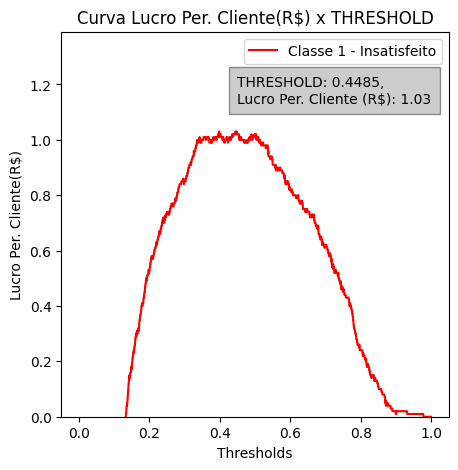

In [76]:
thresholdsCurve(yVal, yPred_prob)

In [79]:
yPred_prob_train = classifierXGB.predict_proba(dfTrainCLF)
yPred_prob = classifierXGB.predict_proba(dfValCLF)

yPred = yPred_prob[:,1] >= 0.4485
profitClient, profit = scoringProfit(yVal, yPred, True)
profitClientMax, profitMax = scoringProfit(yVal, yVal, True)

print(f'Lucro máximo por cliente {profitClient:,.2f}')
print(f'Lucro máximo da campanha: R$ {profit:,.2f}')
print(f'Lucro máximo que poderia ser atingindo na campanha: R$ {profitMax:,.2f}')
print(f'Lucro máximo em %: {profit/profitMax:.2%}')

Lucro máximo por cliente 1.03
Lucro máximo da campanha: R$ 14,440.00
Lucro máximo que poderia ser atingindo na campanha: R$ 47,700.00
Lucro máximo em %: 30.27%


In [77]:
yPred_prob_train = classifierLGBM.predict_proba(dfTrainCLF)
yPred_prob = classifierLGBM.predict_proba(dfValCLF)

yPred = yPred_prob[:,1] >= 0.6355
profitClient, profit = scoringProfit(yVal, yPred, True)
profitClientMax, profitMax = scoringProfit(yVal, yVal, True)

print(f'Lucro máximo por cliente {profitClient:,.2f}')
print(f'Lucro máximo da campanha: R$ {profit:,.2f}')
print(f'Lucro máximo que poderia ser atingindo na campanha: R$ {profitMax:,.2f}')
print(f'Lucro máximo em %: {profit/profitMax:.2%}')

Lucro máximo por cliente 1.02
Lucro máximo da campanha: R$ 14,310.00
Lucro máximo que poderia ser atingindo na campanha: R$ 47,700.00
Lucro máximo em %: 30.00%


## 1.5 - Explicabilidade do Melhor Modelo (SHAP Values)

In [59]:
shap.initjs()
explainer = shap.TreeExplainer(classifierXGB)
shap_values = explainer.shap_values(dfValCLF)

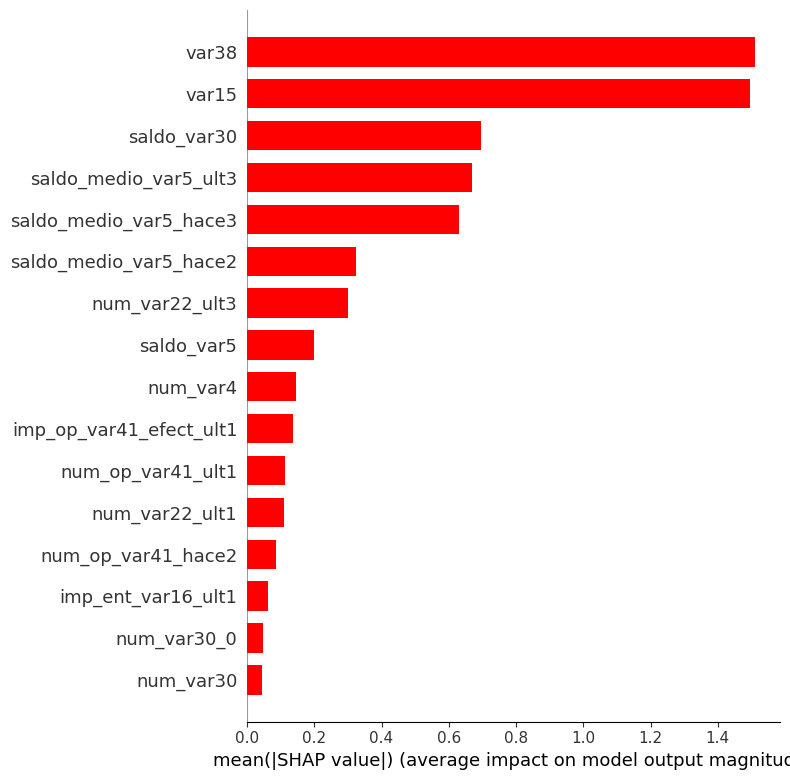

In [65]:
shap.summary_plot(shap_values, dfValCLF, feature_names=modelTransform.get_feature_names_out(), plot_type="bar", color="red")

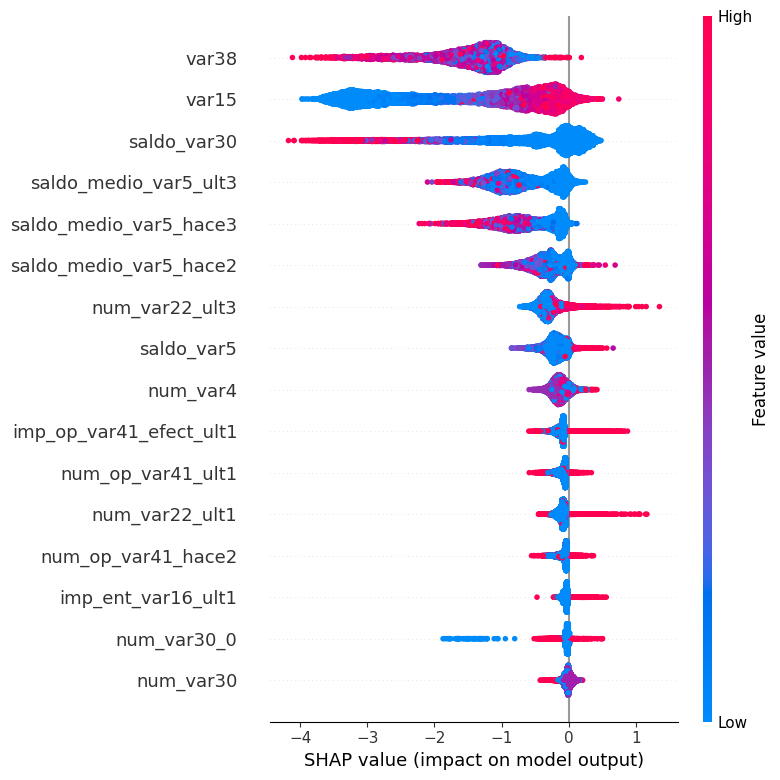

In [63]:
shap.summary_plot(shap_values, dfValCLF, feature_names=modelTransform.get_feature_names_out())

# 2.0 - Notas (Case B)

In [80]:
yPred_prob_test = classifierXGB.predict_proba(dfTestCLF)

A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo


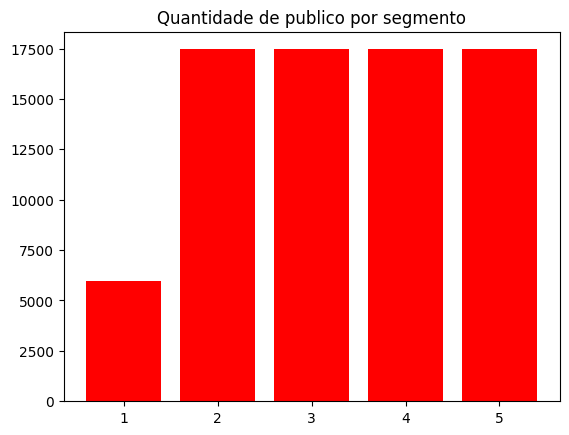

In [81]:
# ### Separar os clientes classificados como insatisfeitos pelo modelo
df_preds_1 =  pd.DataFrame(yPred_prob_test[yPred_prob_test[:,1] >= 0.4485][:,1] >= 0.4485)
df_preds_0 =  pd.DataFrame(yPred_prob_test[yPred_prob_test[:,1] < 0.4485][:,1])

# ### Dividir os registros classificados como satisfeitos em quartis baseados na probabilidade de serem insatisfeitos
decil_preds_0 = pd.qcut(df_preds_0[0].rank(method='first'), q = 4, labels = [2, 3, 4, 5])
pub_segmentado = np.concatenate((df_preds_1, decil_preds_0), axis=None)
segmentos, quantidade = np.unique(pub_segmentado, return_counts=True)

# ### Plot
plt.bar(segmentos, quantidade, color='red')
plt.title('Quantidade de publico por segmento');
print('A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo')


# 3.0 - Clustering (Agrupamento)

In [101]:
def optimalNumberClustersElbow(wcss, min_cluster, max_cluster):
    '''
        Compute the best number of cluster based on Elbow method
    '''
    
    x1, y1 = min_cluster, wcss[0]
    x2, y2 = (max_cluster-1), wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + min_cluster

In [102]:
def computeBestCluster(data, min_cluster=4, max_cluster=21):
    '''
        Compute the best number of cluster based on Silhueta Score
    '''
    
    wcss = []
    scores_silhueta = []
    scores_calinski = []
    scores_davies = []
    
    for nClusters in range(min_cluster, max_cluster):
        
        # ### Train kmeans model
        kmeans_model = KMeans(n_clusters = nClusters, n_init=50, random_state = 42)
        kmeans_model.fit(data)
        
        # ### Predict
        pred = kmeans_model.predict(data)
    
        # ### Compute WCSS (Elbow)
        wcss.append(kmeans_model.inertia_)
        
        # ### Compute silhouette score
        score_sil = silhouette_score(data, pred)
        score_dav = davies_bouldin_score(data, pred)
        score_cal = calinski_harabasz_score(data, pred)
        
        scores_silhueta.append(score_sil)
        scores_davies.append(score_dav)
        scores_calinski.append(score_cal)
        
        print(f'Silhouette Score para {nClusters} clusters: {score_sil:.5f}')
        print(f'Davies Score para {nClusters} clusters: {score_dav:.5f}')
        print(f'Calinski Score para {nClusters} clusters: {score_cal:.5f}\n')

    print(f"\n Melhor número de clusters de acordo com o Silhueta Score {max(scores_silhueta)}: {scores_silhueta.index(max(scores_silhueta)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Davies-Bouldin Score {min(scores_davies)}: {scores_davies.index(min(scores_davies)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Calinski-Harabasz Score {max(scores_calinski)}: {scores_calinski.index(max(scores_calinski)) + min_cluster}")
    print(f"\n Melhor número de clusters de acordo com o Método Elow: {optimalNumberClustersElbow(wcss, min_cluster, max_cluster)}")

    return wcss

In [103]:
def benchKmeas(best_k, x_train_scaled, x_val_scaled, yTrain, yVal):

    model = KMeans(n_clusters = best_k, n_init=50, random_state = 42)
    model.fit(x_train_scaled)

    cluster_train = model.predict(x_train_scaled)
    cluster_val = model.predict(x_val_scaled)

    df_cluster_train = pd.DataFrame({'cluster': cluster_train}).join(yTrain)
    df_cluster_train.columns = ['label','target']

    data_train = pd.crosstab(df_cluster_train['label'],df_cluster_train['target'])
    data_train['Ganho'] = data_train [1]*90 
    data_train['Perda'] = data_train[0]*10
    data_train['Lucro'] = data_train['Ganho'] - data_train['Perda']

    
    df_cluster_val = pd.DataFrame({'cluster': cluster_val}).join(yVal)
    df_cluster_val.columns = ['label','target']

    data_val = pd.crosstab(df_cluster_val['label'],df_cluster_val['target'])
    data_val['Ganho'] = data_val [1]*90 
    data_val['Perda'] = data_val[0]*10
    data_val['Lucro'] = data_val['Ganho'] - data_val['Perda']

    print(f'Top 3 clusters para o kmeans - Usando {best_k} clusters')
    print('\nTreino:')
    print(data_train.sort_values(by='Lucro', ascending=False).head(3))
    
    print('\nValidação:')
    print(data_val.sort_values(by='Lucro', ascending=False).head(3))

In [104]:
min_cluster=4
max_cluster=21

### 3.1.1 - Testar usando a normalização MinMaxScaler

In [105]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [106]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.46627
Davies Score para 4 clusters: 1.13856
Calinski Score para 4 clusters: 22088.02564

Silhouette Score para 5 clusters: 0.47610
Davies Score para 5 clusters: 1.29750
Calinski Score para 5 clusters: 20755.12544

Silhouette Score para 6 clusters: 0.48793
Davies Score para 6 clusters: 1.20464
Calinski Score para 6 clusters: 20239.23172

Silhouette Score para 7 clusters: 0.49089
Davies Score para 7 clusters: 1.14840
Calinski Score para 7 clusters: 18848.08278

Silhouette Score para 8 clusters: 0.49508
Davies Score para 8 clusters: 1.14183
Calinski Score para 8 clusters: 17968.04469

Silhouette Score para 9 clusters: 0.49735
Davies Score para 9 clusters: 1.16649
Calinski Score para 9 clusters: 17349.26790

Silhouette Score para 10 clusters: 0.47824
Davies Score para 10 clusters: 1.20274
Calinski Score para 10 clusters: 16903.55489

Silhouette Score para 11 clusters: 0.47648
Davies Score para 11 clusters: 1.18919
Calinski Score para 11 clusters: 16303.0

### 3.1.1.1 - Com base na Silhueta Score

In [112]:
benchKmeas(9, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 9 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
8        232    7    630   2320  -1690
6        876   33   2970   8760  -5790
2       1142   44   3960  11420  -7460

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        47    4    360    470   -110
2       284   15   1350   2840  -1490
6       247    6    540   2470  -1930


### 3.1.1.2 - Com base no Davies-Bouldin Score

In [113]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
2        1297   50   4500   12970  -8470
0       11815  458  41220  118150 -76930
3       12701  499  44910  127010 -82100

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        337   19   1710   3370  -1660
0       3067  129  11610  30670 -19060
3       3337  116  10440  33370 -22930


### 3.1.1.3 - Com base no Calinski-Harabasz Score

In [114]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
2        1297   50   4500   12970  -8470
0       11815  458  41220  118150 -76930
3       12701  499  44910  127010 -82100

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        337   19   1710   3370  -1660
0       3067  129  11610  30670 -19060
3       3337  116  10440  33370 -22930


### 3.1.1.4 - Com base no Elbow

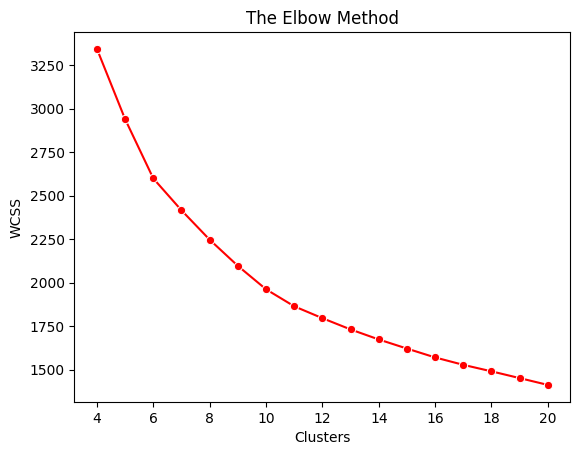

In [115]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [116]:
benchKmeas(10, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 10 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
8        231    6    540   2310  -1770
7        864   31   2790   8640  -5850
3       1139   44   3960  11390  -7430

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        44    4    360    440    -80
3       285   15   1350   2850  -1500
7       243    6    540   2430  -1890


### 3.1.2 - Testar usando a normalização StandardScaler

In [117]:
# ### Scaler feature for clustering
scaler = StandardScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [118]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.51857
Davies Score para 4 clusters: 1.53192
Calinski Score para 4 clusters: 9176.54364

Silhouette Score para 5 clusters: 0.31146
Davies Score para 5 clusters: 1.36291
Calinski Score para 5 clusters: 8916.27388

Silhouette Score para 6 clusters: 0.33501
Davies Score para 6 clusters: 1.34391
Calinski Score para 6 clusters: 8556.53589

Silhouette Score para 7 clusters: 0.33801
Davies Score para 7 clusters: 1.21898
Calinski Score para 7 clusters: 8446.53392

Silhouette Score para 8 clusters: 0.34903
Davies Score para 8 clusters: 1.22405
Calinski Score para 8 clusters: 8317.24040

Silhouette Score para 9 clusters: 0.35423
Davies Score para 9 clusters: 1.31836
Calinski Score para 9 clusters: 8089.52869

Silhouette Score para 10 clusters: 0.35719
Davies Score para 10 clusters: 1.28726
Calinski Score para 10 clusters: 7955.66883

Silhouette Score para 11 clusters: 0.35964
Davies Score para 11 clusters: 1.21750
Calinski Score para 11 clusters: 7933.42723

Si

### 3.1.2.1 - Com base na Silhueta Score

In [119]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1        378    9    810   3780  -2970
3       4288  163  14670  42880 -28210
2       4872  196  17640  48720 -31080

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1         82    4    360    820   -460
3       1130   56   5040  11300  -6260
2       1221   51   4590  12210  -7620


### 3.1.2.2 - Com base no Davies-Bouldin Score

In [124]:
benchKmeas(14, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 14 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
11       26    1     90    260   -170
9        36    2    180    360   -180
7       192   10    900   1920  -1020

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
9        13    2    180    130     50
11        9    1     90     90      0
5        37    4    360    370    -10


### 3.1.2.3 - Com base no Calinski-Harabasz Score

In [121]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1        378    9    810   3780  -2970
3       4288  163  14670  42880 -28210
2       4872  196  17640  48720 -31080

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
1         82    4    360    820   -460
3       1130   56   5040  11300  -6260
2       1221   51   4590  12210  -7620


### 3.1.2.4 - Com base no Elbow

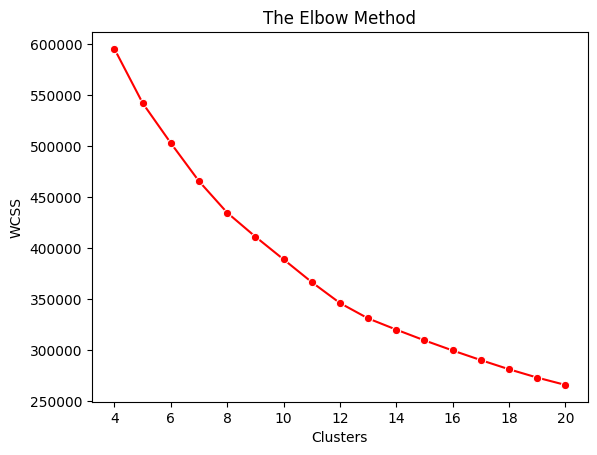

In [122]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [123]:
benchKmeas(11, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 11 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        36    2    180    360   -180
10       36    1     90    360   -270
3       187    5    450   1870  -1420

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        13    2    180    130     50
3        37    4    360    370    -10
10       11    1     90    110    -20


### 3.1.3 - Testar usando a normalização yeo-johnson

In [125]:
# ### Scaler feature for clustering
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [126]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.24802
Davies Score para 4 clusters: 1.51658
Calinski Score para 4 clusters: 10896.69518

Silhouette Score para 5 clusters: 0.26688
Davies Score para 5 clusters: 1.48351
Calinski Score para 5 clusters: 9926.99363

Silhouette Score para 6 clusters: 0.28569
Davies Score para 6 clusters: 1.40096
Calinski Score para 6 clusters: 9282.16924

Silhouette Score para 7 clusters: 0.28571
Davies Score para 7 clusters: 1.26925
Calinski Score para 7 clusters: 8750.71415

Silhouette Score para 8 clusters: 0.28493
Davies Score para 8 clusters: 1.39995
Calinski Score para 8 clusters: 8291.78170

Silhouette Score para 9 clusters: 0.29208
Davies Score para 9 clusters: 1.33200
Calinski Score para 9 clusters: 8162.01317

Silhouette Score para 10 clusters: 0.28577
Davies Score para 10 clusters: 1.29697
Calinski Score para 10 clusters: 7798.40792

Silhouette Score para 11 clusters: 0.28661
Davies Score para 11 clusters: 1.24374
Calinski Score para 11 clusters: 7958.00898

S

### 3.1.3.1 - Com base na Silhueta Score

In [127]:
benchKmeas(9, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 9 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
6          4    0      0     40    -40
2        670   18   1620   6700  -5080
5       2743  131  11790  27430 -15640

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
6         2    0      0     20    -20
2       155   12   1080   1550   -470
7       688   29   2610   6880  -4270


### 3.1.3.2 - Com base no Davies-Bouldin Score

In [128]:
benchKmeas(15, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 15 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
14        3    1     90     30     60
6         1    0      0     10    -10
11        4    0      0     40    -40

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
14        1    0      0     10    -10
11        2    0      0     20    -20
9       135   10    900   1350   -450


### 3.1.3.3 - Com base no Calinski-Harabasz Score

In [129]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
0        5583  203  18270   55830 -37560
1        8347  339  30510   83470 -52960
3       12350  488  43920  123500 -79580

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0       1445   70   6300  14450  -8150
1       2128   84   7560  21280 -13720
3       3244  112  10080  32440 -22360


### 3.1.3.4 - Com base no Elbow

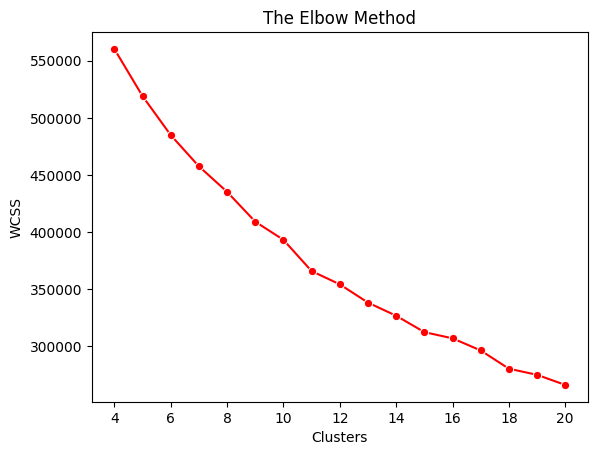

In [131]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [130]:
benchKmeas(11, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 11 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8         1    0      0     10    -10
7         4    0      0     40    -40
9       651   18   1620   6510  -4890

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7         2    0      0     20    -20
9       146   10    900   1460   -560
10      688   29   2610   6880  -4270


## 3.2 - Removendo Dados com duas Labels no Treino e Validação 

In [133]:
def dropDuplicatedWhithDiferrentTargets(df):
    cols = df.columns.drop('TARGET')
    data = df[df[cols].duplicated()]
    remove = []
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            if (data[cols].iloc[i] == data[cols].iloc[j]).all() and data['TARGET'].iloc[i] != data['TARGET'].iloc[j]:
                remove.append(data.index[j])
                remove .append(data.index[i])

    return df.drop(set(remove))
            

In [137]:
dfTrain.shape

(56757, 17)

In [138]:
dfTrain = dropDuplicatedWhithDiferrentTargets(dfTrain)

In [139]:
dfTrain.shape

(56662, 17)

In [140]:
dfVal.shape

(14190, 17)

In [141]:
dfVal = dropDuplicatedWhithDiferrentTargets(dfVal)

In [142]:
dfVal.shape

(14188, 17)

In [143]:
yTrain = dfTrain.TARGET
dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

yVal = dfVal.TARGET
dfVal = dfVal.drop(labels=['TARGET'], axis=1)

### 3.2.1 - Testar usando a normalização MinMaxScaler

In [144]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [145]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.47146
Davies Score para 4 clusters: 1.13173
Calinski Score para 4 clusters: 22642.07085

Silhouette Score para 5 clusters: 0.48183
Davies Score para 5 clusters: 1.29526
Calinski Score para 5 clusters: 21253.03697

Silhouette Score para 6 clusters: 0.49340
Davies Score para 6 clusters: 1.20364
Calinski Score para 6 clusters: 20726.09954

Silhouette Score para 7 clusters: 0.49642
Davies Score para 7 clusters: 1.14879
Calinski Score para 7 clusters: 19346.11926

Silhouette Score para 8 clusters: 0.50053
Davies Score para 8 clusters: 1.14378
Calinski Score para 8 clusters: 18433.56505

Silhouette Score para 9 clusters: 0.50381
Davies Score para 9 clusters: 1.16752
Calinski Score para 9 clusters: 17791.75362

Silhouette Score para 10 clusters: 0.48439
Davies Score para 10 clusters: 1.20173
Calinski Score para 10 clusters: 17334.48928

Silhouette Score para 11 clusters: 0.48307
Davies Score para 11 clusters: 1.19251
Calinski Score para 11 clusters: 16716.7

### 3.2.1.1 - Com base na Silhueta Score

In [146]:
benchKmeas(9, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 9 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
8        234   10    900   2340  -1440
6        888   33   2970   8880  -5910
2       1167   41   3690  11670  -7980

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
4       784   90   8100   7840    260
8        52    0      0    520   -520
6       250    6    540   2500  -1960


### 3.2.1.2 - Com base no Davies-Bouldin Score

In [147]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
2        1325   47   4230   13250  -9020
0       13103  609  54810  131030 -76220
1       12218  456  41040  122180 -81140

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        356    4    360   3560  -3200
0       3307  222  19980  33070 -13090
1       3129  121  10890  31290 -20400


### 3.2.1.3 - Com base no Calinski-Harabasz Score

In [148]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
2        1325   47   4230   13250  -9020
0       13103  609  54810  131030 -76220
1       12218  456  41040  122180 -81140

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        356    4    360   3560  -3200
0       3307  222  19980  33070 -13090
1       3129  121  10890  31290 -20400


### 3.2.1.4 - Com base no Elbow

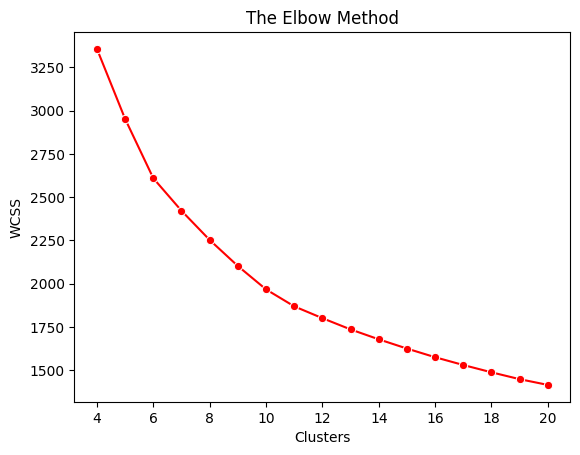

In [149]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [150]:
benchKmeas(10, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 10 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
9        231   10    900   2310  -1410
2        873   32   2880   8730  -5850
4       1166   41   3690  11660  -7970

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
3       821   97   8730   8210    520
9        50    0      0    500   -500
2       245    6    540   2450  -1910


### 3.2.2 - Testar usando a normalização StandardScaler

In [151]:
# ### Scaler feature for clustering
scaler = StandardScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [152]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.52348
Davies Score para 4 clusters: 1.52858
Calinski Score para 4 clusters: 9359.03262

Silhouette Score para 5 clusters: 0.31683
Davies Score para 5 clusters: 1.36192
Calinski Score para 5 clusters: 9103.53767

Silhouette Score para 6 clusters: 0.34027
Davies Score para 6 clusters: 1.34593
Calinski Score para 6 clusters: 8737.55825

Silhouette Score para 7 clusters: 0.34324
Davies Score para 7 clusters: 1.21732
Calinski Score para 7 clusters: 8624.88180

Silhouette Score para 8 clusters: 0.35431
Davies Score para 8 clusters: 1.22207
Calinski Score para 8 clusters: 8492.09933

Silhouette Score para 9 clusters: 0.36060
Davies Score para 9 clusters: 1.31528
Calinski Score para 9 clusters: 8263.99175

Silhouette Score para 10 clusters: 0.36306
Davies Score para 10 clusters: 1.24229
Calinski Score para 10 clusters: 8149.07276

Silhouette Score para 11 clusters: 0.36586
Davies Score para 11 clusters: 1.21278
Calinski Score para 11 clusters: 8124.59284

Si

### 3.2.2.1 - Com base na Silhueta Score

In [153]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        382   15   1350   3820  -2470
3       4399  156  14040  43990 -29950
1       4939  203  18270  49390 -31120

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2         87    0      0    870   -870
1       1200   68   6120  12000  -5880
3       1181   13   1170  11810 -10640


### 3.2.2.2 - Com base no Davies-Bouldin Score

In [154]:
benchKmeas(14, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 14 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8        31    3    270    310    -40
10       28    1     90    280   -190
5       182    8    720   1820  -1100

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
2        42    9    810    420    390
10        8    2    180     80    100
8        12    0      0    120   -120


### 3.2.2.3 - Com base no Calinski-Harabasz Score

In [155]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2        382   15   1350   3820  -2470
3       4399  156  14040  43990 -29950
1       4939  203  18270  49390 -31120

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
2         87    0      0    870   -870
1       1200   68   6120  12000  -5880
3       1181   13   1170  11810 -10640


### 3.2.2.4 - Com base no Elbow

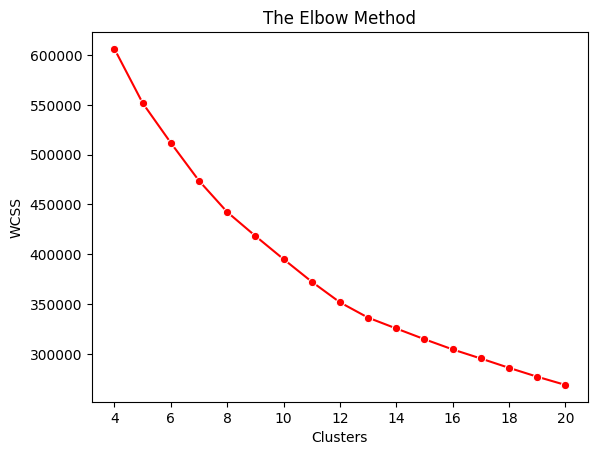

In [156]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [157]:
benchKmeas(11, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 11 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7        37    3    270    370   -100
9        36    1     90    360   -270
6       184    8    720   1840  -1120

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
9         9    2    180     90     90
7        15    0      0    150   -150
6        42    0      0    420   -420


### 3.2.3 - Testar usando a normalização yeo-johnson

In [158]:
# ### Scaler feature for clustering
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(dfTrain)

# ### Apply in train and val
x_train_scaled = scaler.transform(dfTrain)
x_val_scaled = scaler.transform(dfVal)

In [159]:
# ### Calcular o melhor Cluster
wcss = computeBestCluster(x_train_scaled, min_cluster, max_cluster)

Silhouette Score para 4 clusters: 0.25110
Davies Score para 4 clusters: 1.51344
Calinski Score para 4 clusters: 11124.91471

Silhouette Score para 5 clusters: 0.26995
Davies Score para 5 clusters: 1.48020
Calinski Score para 5 clusters: 10135.74606

Silhouette Score para 6 clusters: 0.28895
Davies Score para 6 clusters: 1.39765
Calinski Score para 6 clusters: 9479.74695

Silhouette Score para 7 clusters: 0.27862
Davies Score para 7 clusters: 1.41150
Calinski Score para 7 clusters: 8928.22393

Silhouette Score para 8 clusters: 0.28889
Davies Score para 8 clusters: 1.39525
Calinski Score para 8 clusters: 8472.16717

Silhouette Score para 9 clusters: 0.28563
Davies Score para 9 clusters: 1.36442
Calinski Score para 9 clusters: 8325.15119

Silhouette Score para 10 clusters: 0.28607
Davies Score para 10 clusters: 1.25214
Calinski Score para 10 clusters: 8208.53863

Silhouette Score para 11 clusters: 0.21317
Davies Score para 11 clusters: 1.26069
Calinski Score para 11 clusters: 7850.83296



### 3.2.3.1 - Com base na Silhueta Score

In [160]:
benchKmeas(15, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 15 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
7         1    0      0     10    -10
6         4    0      0     40    -40
14        4    0      0     40    -40

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
6         1    1     90     10     80
14        1    0      0     10    -10
12       70    1     90    700   -610


### 3.2.3.2 - Com base no Davies-Bouldin Score

In [161]:
benchKmeas(20, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 20 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
10        1    0      0     10    -10
14        1    0      0     10    -10
9         3    0      0     30    -30

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
8       974  145  13050   9740   3310
9         0    1     90      0     90
18        1    0      0     10    -10


### 3.2.3.3 - Com base no Calinski-Harabasz Score

In [162]:
benchKmeas(4, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 4 clusters

Treino:
target    0.0  1.0  Ganho   Perda  Lucro
label                                   
1        5729  194  17460   57290 -39830
3        8541  321  28890   85410 -56520
0       12746  593  53370  127460 -74090

Validação:
target   0.0  1.0  Ganho  Perda  Lucro
label                                 
0       3210  221  19890  32100 -12210
3       2138   96   8640  21380 -12740
1       1511   18   1620  15110 -13490


### 3.2.3.4 - Com base no Elbow

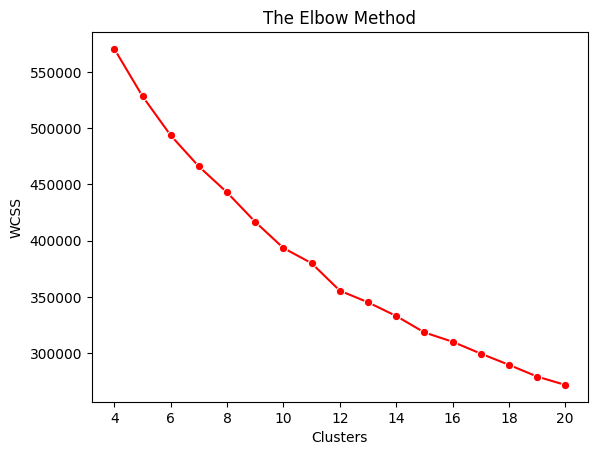

In [163]:
mycenters = pd.DataFrame({'Clusters' : range(min_cluster, max_cluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [164]:
benchKmeas(12, x_train_scaled, x_val_scaled, yTrain, yVal)

Top 3 clusters para o kmeans - Usando 12 clusters

Treino:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
9         1    0      0     10    -10
8         4    0      0     40    -40
10        4    0      0     40    -40

Validação:
target  0.0  1.0  Ganho  Perda  Lucro
label                                
10        1    1     90     10     80
8         1    0      0     10    -10
1       154    0      0   1540  -1540


In [7]:
dropDuplicatedRows(dfTest, dfTest.columns, 'last')

Dataset antes do processamento: (75818, 25)
Dataset após o processamento: (69246, 25)
